# 14.1e: Temperature Dynamics of the Primordial Atom

**How hot is the primordial atom, and how fast does it cool?**

## The Question

Dead tokens start clustered in a primordial atom at norm ~1. They receive weak, noisy gradients every step that cause them to:
1. **Fall** toward the origin (net downward pressure from cross-entropy loss)
2. **Boil** internally (thermal agitation from gradient noise)
3. **Cool** over time (gradients decay → less motion)

We can quantify this by defining **temperature** as the average velocity (step-to-step displacement) of tokens.

## Temperature Metrics

For a set of tokens at step t:

**L2 temperature:**
$$T_{L2}(t) = \langle \|\Delta \text{embedding}_i(t)\|_2 \rangle$$

Average Euclidean distance traveled per token.

**L∞ temperature:**
$$T_{L\infty}(t) = \langle \|\Delta \text{embedding}_i(t)\|_\infty \rangle$$

Average max-component change per token (relevant for bfloat16 quantization).

## Populations

We compute temperature separately for:
- **Dead tokens** (51 tokens, never appear in corpus)
- **Live tokens** (10 sampled, appear in corpus)
- **All tokens** (dead + live combined)

## Parameters

In [15]:
# Data
DATA_PATH = "../data/instrumented_run/gradient_delta_history.safetensors"

# Visualization
DPI = 200

RANDOM_SEED = 42

## Imports

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [17]:
print(f"Loading: {DATA_PATH}")

data = load_file(DATA_PATH)

recorded_steps = data['recorded_steps'].numpy()
dead_token_ids = data['dead_token_ids'].tolist()
live_token_ids = data['live_token_ids'].tolist()

dead_deltas = data['dead_deltas']  # [n_recorded, n_dead, hidden_dim]
live_deltas = data['live_deltas']  # [n_recorded, n_live, hidden_dim]

n_recorded = len(recorded_steps)
n_dead = len(dead_token_ids)
n_live = len(live_token_ids)

print(f"\n  Recorded steps: {n_recorded}")
print(f"  Step range: {recorded_steps[0]} to {recorded_steps[-1]}")
print(f"  Dead tokens: {n_dead}")
print(f"  Live tokens: {n_live}")
print(f"\n✓ Data loaded")

Loading: ../data/instrumented_run/gradient_delta_history.safetensors

  Recorded steps: 1001
  Step range: 0 to 10000
  Dead tokens: 51
  Live tokens: 10

✓ Data loaded


## Compute Temperatures

We already have deltas (step-to-step changes), so temperature is just the average norm of these deltas.

In [18]:
print("Computing temperatures...")

# L2 norms
dead_L2_norms = torch.norm(dead_deltas, p=2, dim=2)  # [n_recorded, n_dead]
live_L2_norms = torch.norm(live_deltas, p=2, dim=2)  # [n_recorded, n_live]

# L∞ norms (max absolute component)
dead_Linf_norms = torch.abs(dead_deltas).max(dim=2)[0]  # [n_recorded, n_dead]
live_Linf_norms = torch.abs(live_deltas).max(dim=2)[0]  # [n_recorded, n_live]

# Temperatures (mean over tokens at each step)
T_dead_L2 = dead_L2_norms.mean(dim=1).numpy()  # [n_recorded]
T_live_L2 = live_L2_norms.mean(dim=1).numpy()

T_dead_Linf = dead_Linf_norms.mean(dim=1).numpy()
T_live_Linf = live_Linf_norms.mean(dim=1).numpy()

# Combined (weighted average by population size)
T_all_L2 = (n_dead * T_dead_L2 + n_live * T_live_L2) / (n_dead + n_live)
T_all_Linf = (n_dead * T_dead_Linf + n_live * T_live_Linf) / (n_dead + n_live)

print(f"✓ Temperatures computed")

Computing temperatures...
✓ Temperatures computed


## Plot 1: L2 Temperature (Euclidean Velocity)

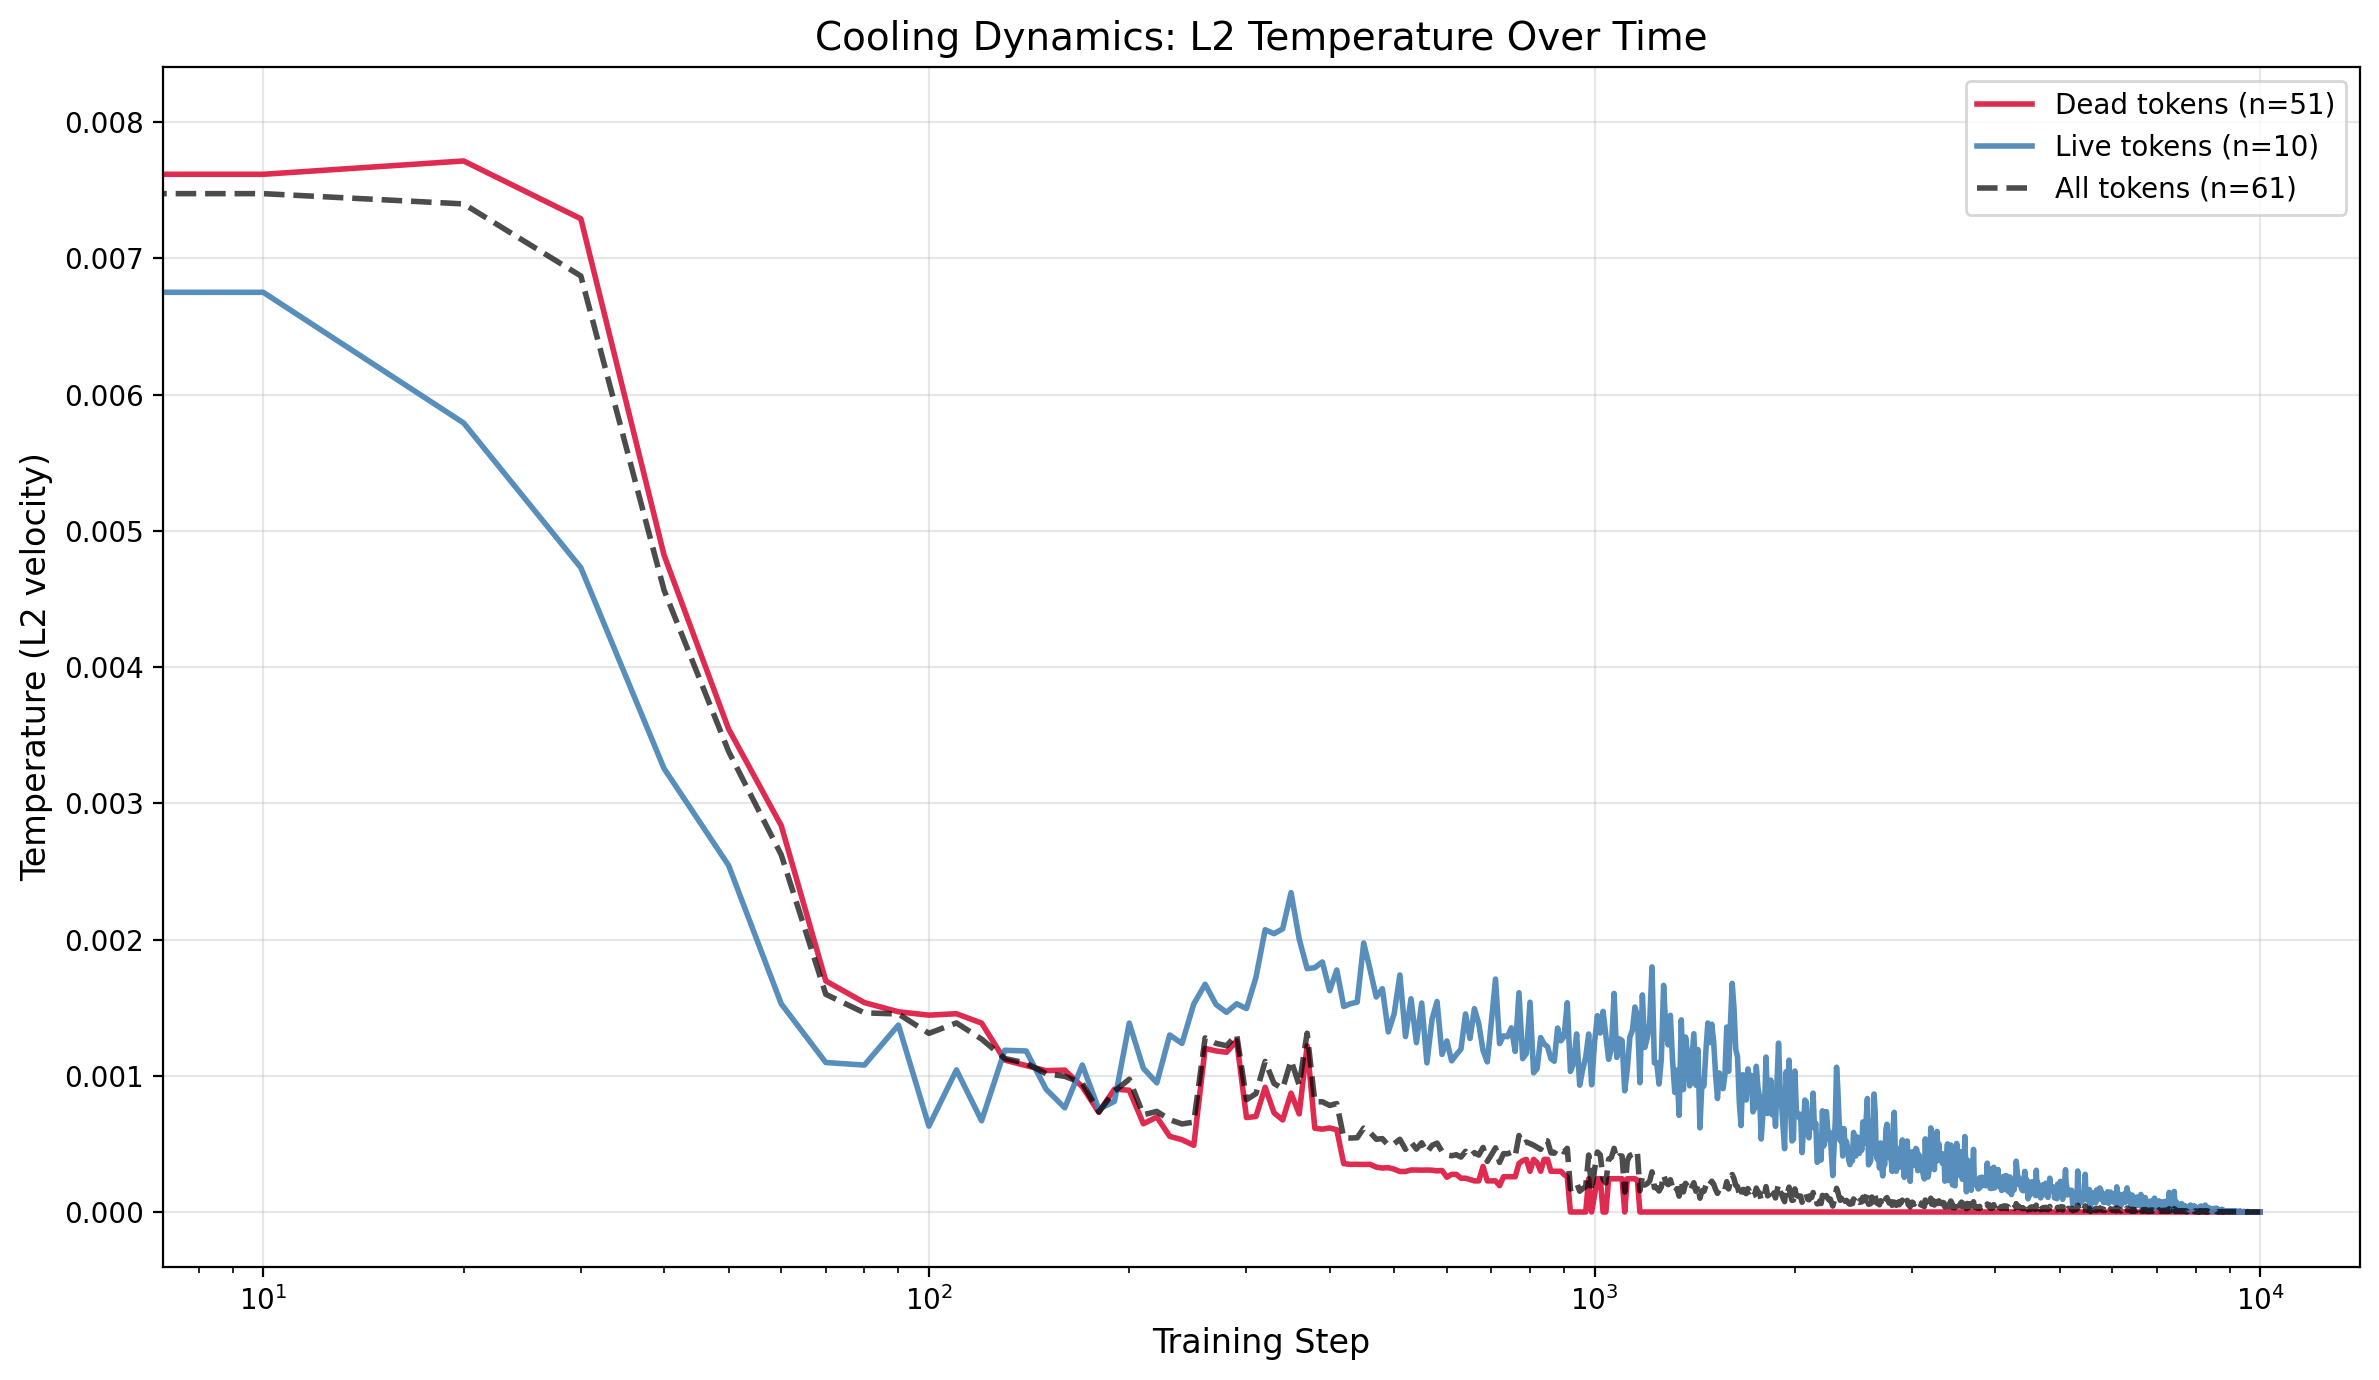


✓ L2 temperature plot complete


In [25]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=DPI)

ax.plot(recorded_steps, T_dead_L2, linewidth=2, color='crimson', label=f'Dead tokens (n={n_dead})', alpha=0.9)
ax.plot(recorded_steps, T_live_L2, linewidth=2, color='steelblue', label=f'Live tokens (n={n_live})', alpha=0.9)
ax.plot(recorded_steps, T_all_L2, linewidth=2, color='black', label=f'All tokens (n={n_dead + n_live})', linestyle='--', alpha=0.7)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Temperature (L2 velocity)', fontsize=12)
ax.set_title('Cooling Dynamics: L2 Temperature Over Time', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xscale('log')
# ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ L2 temperature plot complete")

## Plot 2: L∞ Temperature (Max Component Velocity)

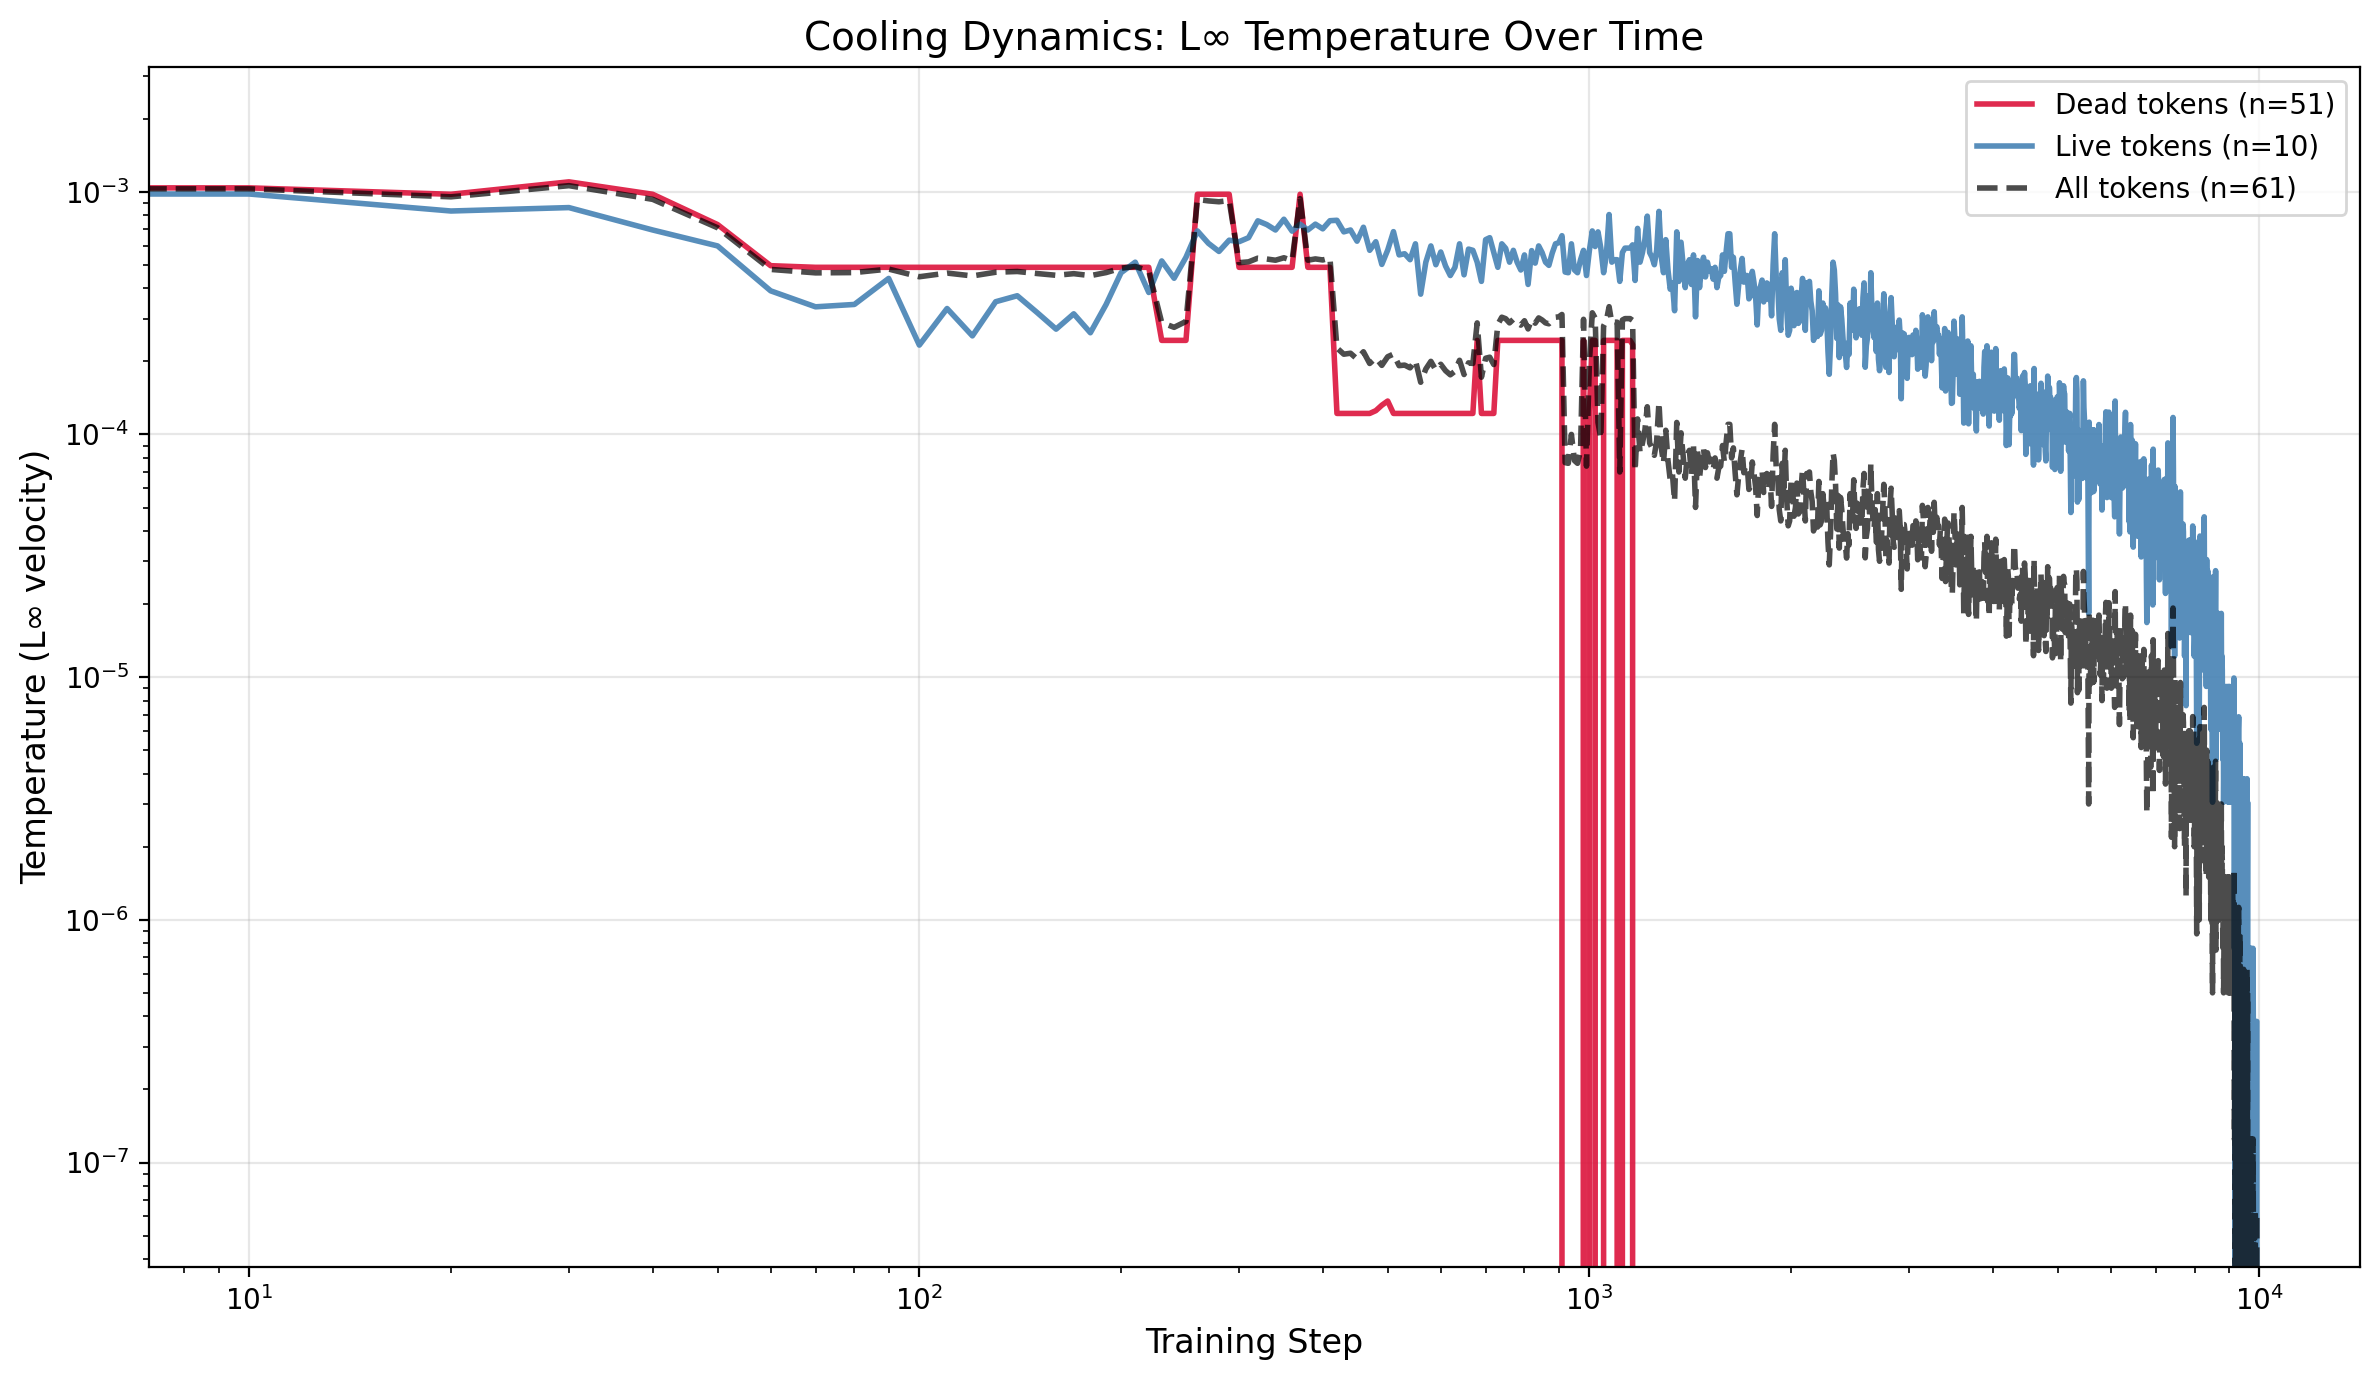


✓ L∞ temperature plot complete


In [26]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=DPI)

ax.plot(recorded_steps, T_dead_Linf, linewidth=2, color='crimson', label=f'Dead tokens (n={n_dead})', alpha=0.9)
ax.plot(recorded_steps, T_live_Linf, linewidth=2, color='steelblue', label=f'Live tokens (n={n_live})', alpha=0.9)
ax.plot(recorded_steps, T_all_Linf, linewidth=2, color='black', label=f'All tokens (n={n_dead + n_live})', linestyle='--', alpha=0.7)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Temperature (L∞ velocity)', fontsize=12)
ax.set_title('Cooling Dynamics: L∞ Temperature Over Time', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ L∞ temperature plot complete")

## Statistics

In [27]:
print(f"\n{'='*80}")
print(f"TEMPERATURE DYNAMICS SUMMARY")
print(f"{'='*80}\n")

print(f"L2 Temperature (Euclidean velocity):")
print(f"  Dead tokens:")
print(f"    Initial (step {recorded_steps[0]}): {T_dead_L2[0]:.6e}")
print(f"    Final (step {recorded_steps[-1]}): {T_dead_L2[-1]:.6e}")
print(f"    Ratio (final/initial): {T_dead_L2[-1] / T_dead_L2[0]:.6f}")

print(f"\n  Live tokens:")
print(f"    Initial (step {recorded_steps[0]}): {T_live_L2[0]:.6e}")
print(f"    Final (step {recorded_steps[-1]}): {T_live_L2[-1]:.6e}")
print(f"    Ratio (final/initial): {T_live_L2[-1] / T_live_L2[0]:.6f}")

print(f"\nL∞ Temperature (max component velocity):")
print(f"  Dead tokens:")
print(f"    Initial (step {recorded_steps[0]}): {T_dead_Linf[0]:.6e}")
print(f"    Final (step {recorded_steps[-1]}): {T_dead_Linf[-1]:.6e}")
print(f"    Ratio (final/initial): {T_dead_Linf[-1] / T_dead_Linf[0]:.6f}")

print(f"\n  Live tokens:")
print(f"    Initial (step {recorded_steps[0]}): {T_live_Linf[0]:.6e}")
print(f"    Final (step {recorded_steps[-1]}): {T_live_Linf[-1]:.6e}")
print(f"    Ratio (final/initial): {T_live_Linf[-1] / T_live_Linf[0]:.6f}")

print(f"\n{'='*80}")


TEMPERATURE DYNAMICS SUMMARY

L2 Temperature (Euclidean velocity):
  Dead tokens:
    Initial (step 0): 8.006398e-03
    Final (step 10000): 0.000000e+00
    Ratio (final/initial): 0.000000

  Live tokens:
    Initial (step 0): 8.004586e-03
    Final (step 10000): 0.000000e+00
    Ratio (final/initial): 0.000000

L∞ Temperature (max component velocity):
  Dead tokens:
    Initial (step 0): 1.953125e-03
    Final (step 10000): 0.000000e+00
    Ratio (final/initial): 0.000000

  Live tokens:
    Initial (step 0): 1.953125e-03
    Final (step 10000): 0.000000e+00
    Ratio (final/initial): 0.000000



## Interpretation

**What we're looking for:**

1. **Exponential cooling?** Do temperatures decay exponentially (straight line on log-log plot)?
2. **Dead vs live?** Do dead tokens cool faster/slower than live tokens?
3. **L2 vs L∞?** Do the two metrics tell different stories?
4. **Freeze point?** When does temperature drop below ~1 ULP (indicating freeze)?

**Expected behavior:**
- Early: High temperature (large gradients → big updates)
- Mid: Exponential cooling (gradients decay → smaller updates)
- Late: Plateau near zero (updates below quantization threshold → frozen)

**L∞ vs L2:**
- L∞ more relevant for bfloat16 quantization (per-component)
- L2 more natural for measuring "distance traveled"
- Both should show similar trends but different absolute scales